## Imports

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install easydev                 #version 0.12.0
!pip install colormap                #version 1.0.4
!pip install opencv-python           #version 4.5.5.64
!pip install colorgram.py            #version 1.2.0
!pip install extcolors 

     |████████████████████████████████| 85 kB 1.6 MB/s 
     |████████████████████████████████| 4.3 MB 13.8 MB/s 
     |████████████████████████████████| 98 kB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 3.3 MB/s 
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=03541972c6ae1a15bc160fef222b6910e1ad72a60461c271609c5fcd154f7f40
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built easydev
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormap: filename=colormap-1.0.4-py3-none-any.whl size=15637 sha256=72c8befedb823cd3df9afc3a48e27eea9ce969832861b1ae516019a6f5fc7c4d
  Stored in directory: /root/.cache/pip/wheels/71/35/4b/259c328e39ede29b184e4ffe4443bcc2be4e475178a83794c3
Successfully built colormap


In [ ]:
import pandas as pd
import numpy as np

import os 
import io 
import zipfile 
from zipfile import ZipFile 
import requests 
import tensorflow as tf
from glob import glob
import PIL
import PIL.Image
from PIL import Image

from tqdm import tqdm
import time


import pprint
import tempfile

from typing import Dict, Text

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour

from skimage import measure            # to find shape contour
import scipy.ndimage as ndi            # to determine shape centrality

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import cv2
import extcolors

from colormap import rgb2hex


from skimage.io import imread, imshow, imread_collection, imshow_collection
from skimage.transform import rescale, resize, downscale_local_mean


# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6,6) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# preparing the dataset

In [ ]:
# ZIP 파일 풀어주기
"""
path_to_zip_file = '/content/drive/MyDrive/kaggle/H&M/data/h-and-m-personalized-fashion-recommendations.zip'
directory_to_extract_to = '/content/drive/MyDrive/kaggle/H&M/data'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
"""

In [ ]:
#읽어오기
articles = pd.read_csv('/content/drive/MyDrive/kaggle/H&M/data/articles.csv')
customers = pd.read_csv('/content/drive/MyDrive/kaggle/H&M/data/customers.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/kaggle/H&M/data/sample_submission.csv')
transactions = pd.read_csv('/content/drive/MyDrive/kaggle/H&M/data/transactions_train.csv')

In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [ ]:
customer_id_list = transactions['customer_id'].unique()

In [ ]:
# customer_id 10000개만 사용
transactions_train = transactions.sort_values(by=['customer_id'])
transactions_train = transactions_train.reset_index(drop=True)
transactions_train = transactions_train[:237300]

# Image feature extraction

### color extraction

https://towardsdatascience.com/image-color-extraction-with-python-in-4-steps-8d9370d9216e

In [ ]:
article_id_list = transactions_train['article_id'].unique().astype('str')

In [ ]:
article_id_list = list(map(lambda x:'0'+x, article_id_list))

In [ ]:
'745232001' in article_id_list

True

In [ ]:
'0389388001' in article_id_list

False

In [ ]:
import os
path_dir = '../content/drive/MyDrive/kaggle/H&M/data/images'
file_list = os.listdir(path_dir)

image_name = []

for lis in file_list:
  sub_list = path_dir+'/'+lis
  sub_file_list = os.listdir(sub_list)
  for img in sub_file_list:
    img_name = img[:-4]
    if img_name in article_id_list:
      print(img_name,'가 존재')
      img = sub_list+'/'+img
      image_name.append(img)
    else:
      print(img_name,'가 없음')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0893432005 가 없음
0893441001 가 없음
0893441002 가 없음
0893444001 가 없음
0893444002 가 없음
0893444003 가 없음
0893444006 가 없음
0893452001 가 없음
0893454001 가 없음
0893454004 가 없음
0893454005 가 없음
0893537001 가 없음
0893539001 가 없음
0893541001 가 없음
0893542001 가 없음
0893556001 가 없음
0893556003 가 없음
0893562001 가 없음
0893562002 가 없음
0893564001 가 없음
0893578001 가 없음
0893580001 가 없음
0893589001 가 없음
0893635001 가 없음
0893637001 가 없음
0893637002 가 없음
0893638001 가 없음
0893638002 가 없음
0893638003 가 없음
0893644001 가 없음
0893644002 가 없음
0893651001 가 없음
0893663001 가 없음
0893663002 가 없음
0893668001 가 없음
0893668002 가 없음
0893668003 가 없음
0893679001 가 없음
0893691001 가 없음
0893691002 가 없음
0893714001 가 없음
0893730001 가 없음
0893733001 가 없음
0893733002 가 없음
0893750002 가 없음
0893750008 가 없음
0893752001 가 없음
0893752002 가 없음
0893757003 가 없음
0893766001 가 없음
0893767001 가 없음
0893768001 가 없음
0893769001 가 없음
0893770001 가 없음
0893771001 가 없음
0893795001 가 없음
0893796002 가 없음
0893798001 가 없음
0893820001 가 없음
0893822001 가 없음
0893

In [ ]:
def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [int(i.split('), ')[1].replace(')','')) for i in colors_pre_list]

    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
 
    return df_color_up

In [ ]:
def exact_color(input_image, resize, tolerance, zoom, dic):
    resize_name =  input_image
    
    #crate dataframe
    img_url = resize_name
    colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance, limit = 13)
    color_list = color_to_df(colors_x)
    name = resize_name[-14:-4]
    dic[name] = ' '.join(color_list)

In [ ]:
ex = image_name[155]

In [ ]:
color_dic = {}
for i in tqdm(image_name):
  exact_color(i,900,30,1.2,color_dic)

 82%|████████▏ | 16318/20000 [10:03:06<2:16:05,  2.22s/it]


KeyboardInterrupt: ignored

In [ ]:
df_color_dic = pd.DataFrame(list(color_dic.items()),columns=['name','color'])

In [ ]:
df_color_dic.to_csv('/content/drive/MyDrive/kaggle/H&M/data/image_colors.csv')

In [ ]:
len(image_name)

83389

In [ ]:
from pandas.core.groupby.generic import DataFrameGroupBy
# 시각화
def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])

    # 배경 지우기
    if len(df[df['c_code'].str.contains('FFF',)]) != 0:
      df = df[~df['c_code'].str.contains("FFF", na=False, case=False)]
    else:
      df = df[1:]

    df = df[:5]
    return df

def exact_color(input_image, resize, tolerance, zoom):
    #background
    bg = 'bg.png'
    fig, ax = plt.subplots(figsize=(192,108),dpi=10)
    fig.set_facecolor('white')
    plt.savefig(bg)
    plt.close(fig)
    
    resize_name = input_image
    
    #crate dataframe
    img_url = resize_name
    colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance, limit = 13)
    df_color = color_to_df(colors_x)
    
    #annotate text
    list_color = list(df_color['c_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color, list_precent)]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(160,120), dpi = 10)
    
    #donut plot
    wedges, text = ax1.pie(list_precent,
                           labels= text_c,
                           labeldistance= 1.05,
                           colors = list_color,
                           textprops={'fontsize': 150, 'color':'black'})
    plt.setp(wedges, width=0.3)

    #add image in the center of donut plot
    img = mpimg.imread(resize_name)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (0, 0))
    ax1.add_artist(ab)
    
    #color palette
    x_posi, y_posi, y_posi2 = 160, -170, -170
    for c in list_color:
        if list_color.index(c) <= 5:
            y_posi += 180
            rect = patches.Rectangle((x_posi, y_posi), 360, 160, facecolor = c)
            ax2.add_patch(rect)
            ax2.text(x = x_posi+400, y = y_posi+100, s = c, fontdict={'fontsize': 190})
        else:
            y_posi2 += 180
            rect = patches.Rectangle((x_posi + 1000, y_posi2), 360, 160, facecolor = c)
            ax2.add_artist(rect)
            ax2.text(x = x_posi+1400, y = y_posi2+100, s = c, fontdict={'fontsize': 190})

    fig.set_facecolor('white')
    ax2.axis('off')
    bg = plt.imread('bg.png')
    plt.imshow(bg)       
    plt.tight_layout()
    plt.savefig('color.jpg')
    return plt.show()

In [ ]:
len(image_name)

83389

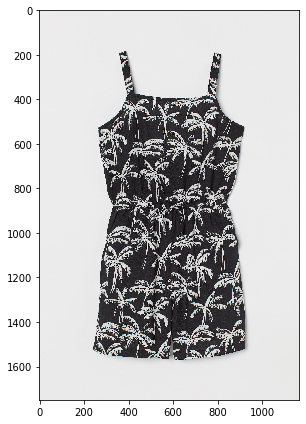

In [ ]:
# 155
ex = image_name[83350]
imshow(ex)

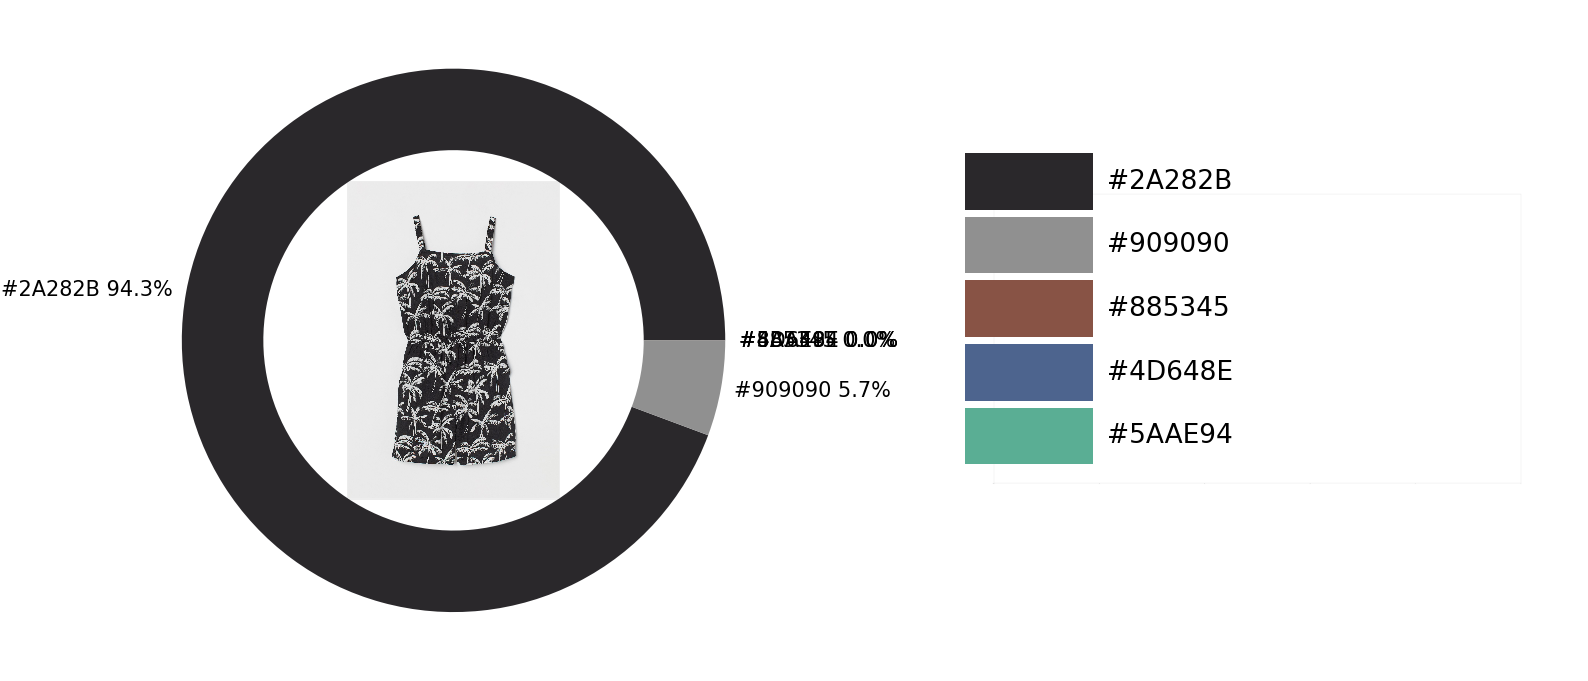

In [ ]:
exact_color(ex, 1, 30, 1.3)

### shape extraction

In [ ]:
img = cv2.imread(ex, cv2.IMREAD_GRAYSCALE)

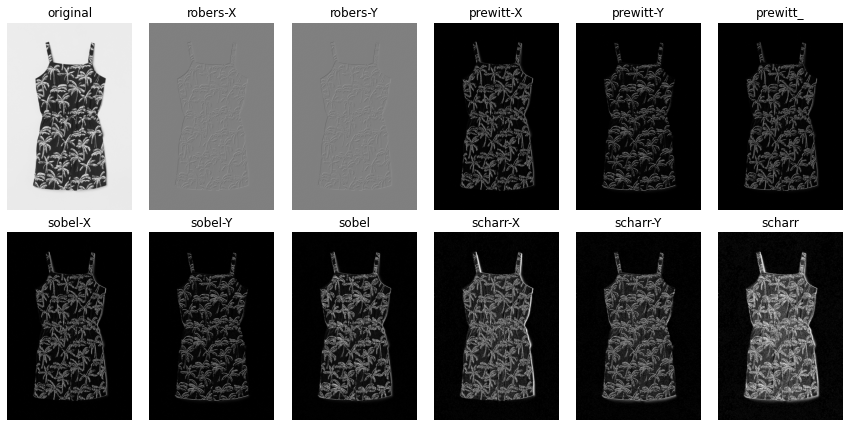

In [ ]:
robertsx = np.array([[-1,0,0],[0,1,0],[0,0,0]])
robertsy = np.array([[0,0,-1],[0,1,0],[0,0,0]])

robertsX = cv2.filter2D(img, cv2.CV_64F, robertsx)
robertsY = cv2.filter2D(img, cv2.CV_64F, robertsx)

prewittx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
prewitty = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
prewitt_ = np.array([[-1,-1,0],[-1,0,1],[0,1,1]])

prewittX = cv2.filter2D(img, -1, prewittx)
prewittY = cv2.filter2D(img, -1, prewitty)
prewitt_ = cv2.filter2D(img, -1, prewitt_)

sobelX = cv2.Sobel(img, -1,1,0,ksize=3)
sobelY = cv2.Sobel(img, -1,0,1,ksize=3)
sobel = sobelX + sobelY

scharrX = cv2.Sobel(img, -1,1,0,ksize = cv2.FILTER_SCHARR)
scharrY = cv2.Sobel(img,-1,0,1,ksize=-1)
scharr = scharrX+scharrY

titles = ['original', 'robers-X', 'robers-Y', 'prewitt-X', 'prewitt-Y', 'prewitt_', 'sobel-X', 'sobel-Y', 'sobel', 'scharr-X', 'scharr-Y', 'scharr']
images = [img, robertsX, robertsY, prewittX, prewittY, prewitt_, sobelX, sobelY, sobel, scharrX, scharrY, scharr]

#cv2_imshow(img)
#cv2_imshow(prewitt_)
#cv2_imshow(sobel)
#cv2_imshow(scharr)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

plt.figure(figsize = (12,6))
for i in range(12):
  plt.subplot(2,6,i+1)
  plt.imshow(images[i],cmap='gray')
  plt.title(titles[i])
  plt.axis('off')

plt.tight_layout()
plt.savefig('shape.png')
plt.show()

In [ ]:
scharr

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 26, 16,  0],
       [ 0,  0,  0, ..., 16, 12, 10],
       [ 0,  0,  0, ...,  0, 10,  0]], dtype=uint8)

# Language feature extraction

In [ ]:
key_list = pd.read_csv('/content/drive/MyDrive/kaggle/H&M/data/key_list.csv', header=None, names = ['key_list'])

In [ ]:
articles_key_list = pd.concat([articles['article_id'],key_list],axis=1)

In [ ]:
articles_key_list['article_id'] = articles_key_list['article_id'].apply(str)

In [ ]:
articles_key_list = articles_key_list.fillna('no')

In [ ]:
articles_key_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   article_id  105542 non-null  object
 1   key_list    105542 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


# Transactions 데이터 가공

In [ ]:
# 시간데이터,문자열로 변경
transactions_train['t_dat'] = pd.to_datetime(transactions_train['t_dat'])
transactions_train['article_id'] = transactions_train['article_id'].apply(str)
transactions_train['sales_channel_id'] = transactions_train['sales_channel_id'].apply(str) 

In [ ]:
transactions_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237300 entries, 0 to 237299
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   t_dat             237300 non-null  datetime64[ns]
 1   customer_id       237300 non-null  object        
 2   article_id        237300 non-null  object        
 3   price             237300 non-null  float64       
 4   sales_channel_id  237300 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 9.1+ MB


In [ ]:
window = 10
lag = 1
train_article = transactions_train
train_time = transactions_train
train_price = transactions_train

In [ ]:
# article_id
for i in range(-1, -1*(window+lag),-1):
  shift_df = transactions_train.groupby(by='customer_id')['article_id'].shift(i)
  train_article = train_article.join(shift_df.rename("article_id"+str(i)))
  train_article = train_article.dropna()

# 시간
for j in range(-1, -1*(window+lag),-1):
  shift_time = transactions_train.groupby(by='customer_id')['t_dat'].shift(j)
  train_time = train_time.join(shift_time.rename("t_dat"+str(j)))
  train_time = train_time.dropna()


# price
for k in range(-1, -1*(window+lag),-1):
  shift_price = transactions_train.groupby(by='customer_id')['price'].shift(k)
  train_price = train_price.join(shift_price.rename("price"+str(k)))
  train_price = train_price.dropna()


In [ ]:
train_article = train_article.drop(['t_dat', 'customer_id','price','sales_channel_id'],axis=1)
train_time = train_time.drop(['customer_id','article_id','price','sales_channel_id','t_dat-10'],axis=1)
train_price = train_price.drop(['t_dat','customer_id','article_id','sales_channel_id','price-10'],axis=1)
train_target = train_article.pop('article_id'+str(-1*(window+lag-1)))

# articles 데이터 가공

In [ ]:
articles_train = articles[['article_id','product_type_name','graphical_appearance_name','section_name']]
articles_train['article_id'] = articles_train['article_id'].apply(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
articles_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 4 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   article_id                 105542 non-null  object
 1   product_type_name          105542 non-null  object
 2   graphical_appearance_name  105542 non-null  object
 3   section_name               105542 non-null  object
dtypes: object(4)
memory usage: 3.2+ MB


In [ ]:
article_train_merge = pd.merge(left=transactions_train, right=articles_train, how='left',on='article_id')

In [ ]:
article_train_merge

,t_dat,customer_id,article_id,price,sales_channel_id,product_type_name,graphical_appearance_name,section_name
0,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,745232001,0.021169,1,Skirt,Denim,Ladies Denim
1,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,890498002,0.031763,2,Jacket,Solid,Divided Collection
2,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,887593002,0.021593,2,Top,Dot,Womens Tailoring
3,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,841260003,0.011508,2,T-shirt,Dot,Womens Everyday Collection
4,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001,0.044051,1,Jacket,Solid,Kids Outerwear
...,...,...,...,...,...,...,...,...
237295,2019-06-17,01dc68579da32eb1411ac53c47ef22a6bc762a000cc79b...,752512008,0.033881,2,Trousers,All over pattern,Womens Everyday Collection
237296,2019-06-10,01dc68579da32eb1411ac53c47ef22a6bc762a000cc79b...,716671005,0.033881,2,Blouse,Solid,Womens Tailoring
237297,2019-06-10,01dc68579da32eb1411ac53c47ef22a6bc762a000cc79b...,716671005,0.033881,2,Blouse,Solid,Womens Tailoring
237298,2020-04-10,01dc68579da32eb1411ac53c47ef22a6bc762a000cc79b...,803757013,0.016932,2,Trousers,Solid,Womens Everyday Basics


In [ ]:
def window_df(df,col_name, window, lag):
  train_df = df
  for i in range(-1, -1*(window+lag),-1):
    shift_df = df.groupby(by='customer_id')[col_name].shift(i)
    train_df = train_df.join(shift_df.rename(col_name+str(i)))
    train_df = train_df.dropna()
  return train_df

In [ ]:
train_product_type_name = window_df(article_train_merge,'product_type_name',10,1)
train_graphical_appearance = window_df(article_train_merge,'graphical_appearance_name',10,1)
train_section_name =window_df(article_train_merge,'section_name',10,1)

In [ ]:
train_product_type_name = train_product_type_name.drop(['t_dat', 'customer_id','article_id','price','sales_channel_id','graphical_appearance_name','section_name','product_type_name-10'],axis=1)
train_graphical_appearance = train_graphical_appearance.drop(['t_dat', 'customer_id','article_id','price','sales_channel_id','product_type_name','section_name','graphical_appearance_name-10'],axis=1)
train_section_name = train_section_name.drop(['t_dat', 'customer_id','article_id','price','sales_channel_id','graphical_appearance_name','product_type_name','section_name-10'],axis=1)

## language 데이터 가공

In [ ]:
key_list_merge = pd.merge(left=transactions_train, right=articles_key_list, how='left',on='article_id')

In [ ]:
key_list_merge

,t_dat,customer_id,article_id,price,sales_channel_id,key_list
0,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,745232001,0.021169,1,Short
1,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,890498002,0.031763,2,Fitted
2,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,887593002,0.021593,2,crêpe
3,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,841260003,0.011508,2,T-shirt
4,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001,0.044051,1,Padded
...,...,...,...,...,...,...
237295,2019-06-17,01dc68579da32eb1411ac53c47ef22a6bc762a000cc79b...,752512008,0.033881,2,Trousers
237296,2019-06-10,01dc68579da32eb1411ac53c47ef22a6bc762a000cc79b...,716671005,0.033881,2,Sleeveless
237297,2019-06-10,01dc68579da32eb1411ac53c47ef22a6bc762a000cc79b...,716671005,0.033881,2,Sleeveless
237298,2020-04-10,01dc68579da32eb1411ac53c47ef22a6bc762a000cc79b...,803757013,0.016932,2,Joggers


In [ ]:
train_key_list = window_df(key_list_merge, 'key_list',10,1)

In [ ]:
train_key_list = train_key_list.drop(['t_dat', 'customer_id','article_id','price','sales_channel_id','key_list-10'],axis=1)

# from tensor slices

In [ ]:
article_index = list(train_article.index)

In [ ]:
import random

In [ ]:
test_index = random.sample(article_index, int(len(article_index)*0.2))

In [ ]:
# 전체 저장
all_article = train_article                         
all_product_type_name = train_product_type_name
all_graphical_appearance = train_graphical_appearance
all_section_name = train_section_name
all_price = train_price
all_key_list = train_key_list
all_target = train_target

In [ ]:
test_article = train_article.loc[test_index]                                      
test_product_type_name = train_product_type_name.loc[test_index]   
test_graphical_appearance =train_graphical_appearance.loc[test_index]   
test_section_name =train_section_name.loc[test_index]  
test_price =train_price.loc[test_index]  
test_key_list = train_key_list.loc[test_index]   
test_target = train_target.loc[test_index]   

In [ ]:
train_article = train_article.drop(test_index, axis=0)                             
train_product_type_name = train_product_type_name.drop(test_index, axis=0)
train_graphical_appearance = train_graphical_appearance.drop(test_index, axis=0)
train_section_name = train_section_name.drop(test_index, axis=0)
train_price = train_price.drop(test_index, axis=0)
train_key_list = train_key_list.drop(test_index, axis=0)
train_target = train_target.drop(test_index, axis=0)

In [ ]:
train = tf.data.Dataset.from_tensor_slices({"context_article_id":train_article.values,            
                                            "product_type_name":train_product_type_name.values,
                                            "graphical_appearance" :train_graphical_appearance.values,
                                            "section_name":train_section_name.values,
                                            "price" : train_price.values, 
                                            "key_list" : train_key_list.values,
                                            "label_article_id":train_target.values})

test = tf.data.Dataset.from_tensor_slices({"context_article_id":test_article.values,
                                            "product_type_name":test_product_type_name.values,
                                            "graphical_appearance" :test_graphical_appearance.values,
                                            "section_name":test_section_name.values,
                                            "price" : test_price.values, 
                                            "key_list" : test_key_list.values,
                                            "label_article_id":test_target.values})

In [ ]:
for x in train.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'context_article_id': array([b'745232001', b'890498002', b'887593002', b'841260003',
       b'625548001', b'176209023', b'627759010', b'797065001',
       b'568601006', b'568601006'], dtype=object),
 'graphical_appearance': array([b'Denim', b'Solid', b'Dot', b'Dot', b'Solid', b'Solid', b'Solid',
       b'Solid', b'Solid', b'Solid'], dtype=object),
 'key_list': array([b'Short', b'Fitted', b'cr\xc3\xaape', b'T-shirt', b'Padded',
       b'Short', b'Padded', b'Fitted', b'Fitted', b'Fitted'], dtype=object),
 'label_article_id': b'656719005',
 'price': array([0.02116949, 0.03176271, 0.02159322, 0.01150847, 0.04405085,
       0.03557627, 0.03049153, 0.05422034, 0.05083051, 0.05083051]),
 'product_type_name': array([b'Skirt', b'Jacket', b'Top', b'T-shirt', b'Jacket', b'Hoodie',
       b'Jacket', b'Blazer', b'Blazer', b'Blazer'], dtype=object),
 'section_name': array([b'Ladies Denim', b'Divided Collection', b'Womens Tailoring',
       b'Womens Everyday Collection', b'Kids Outerwear',
       b'

# 삽질...

In [ ]:
def window_lag(data, features , window=10, lag=1, dropnan=True):
    cols, names = list(),list()
    for i in range(window-1, 0, -1):
        cols.append(data[features].shift(i))
        names += [('%s(t-%d)'%(col,i)) for col in data[features].columns]
    cols.append(data[features])
    names += [('%s(t)'%(col)) for col in data[features].columns]

    for j in range(lag):
        cols.append(data[features].shift(-lag))
        names += [('%s(t+%d)'%(col,lag)) for col in data[features].columns]

        agg = pd.concat(cols, axis=1)
        agg.columns = names

        test_agg = agg.iloc[-1]

    if dropnan:
        agg.dropna(inplace=True)

        cut = int(0.9*len(agg))

        train_agg = agg[:cut]
        valid_agg = agg[cut:]


    return train_agg, valid_agg, test_agg

def list_chunk(lst,n):
    return [lst[i:i+n] for i in range(0, len(lst), n)]

def all_window_lag(data,id, features , window=1, lag=1, dropnan=True):
    customers = data[id].unique()
    chunk_customers = list_chunk(customers,10000)

    print('the number of chunk: ', len(chunk_customers))

    # 나중에 전체 customers로 바꾸기
    cnt = 0
    for chunk in chunk_customers[:2]:
        cnt += 1
        train = pd.DataFrame()
        valid = pd.DataFrame()
        test = pd.DataFrame()

        for cus in tqdm(chunk):
            train_agg, valid_agg, test_agg = window_lag(data[data[id]==cus],features,window,lag)
            train = train.append(train_agg)
            valid = valid.append(valid_agg)
            test = test.append(test_agg)

        train.to_csv('train_'+str(cnt)+'.csv')
        valid.to_csv('valid_'+str(cnt)+'.csv')
        test.to_csv('test_'+str(cnt)+'.csv')

    return train, valid, test

    


In [ ]:
window = 10
lag = 1
all_window_lag(transactions_train, 'customer_id',['article_id'], window, lag)

the number of chunk:  137


  0%|                                                                             | 14/10000 [00:48<8:22:06,  3.02s/it]

KeyboardInterrupt: 

In [ ]:
#train과 valid 이어붙이는거
path = "/content/drive/MyDrive/kaggle/H&M/data/transaction_chunk"
file_list = os.listdir(path)

train_list = [i for i in file_list if 'train' in i]
valid_list = [j for j in file_list if 'valid' in j]
test_list = [k for k in file_list if 'test' in k]


In [ ]:
def concat_the_file(lis):
  df = pd.DataFrame()
  for name in lis:
    dd = pd.read_csv('/content/drive/MyDrive/kaggle/H&M/data/transaction_chunk/'+ name )
    df = pd.concat([df,dd])

  return df

In [ ]:
train = concat_the_file(train_list)
valid = concat_the_file(valid_list)
test = concat_the_file(test_list)

In [ ]:
#article_id를 str형태로 바꿔주기
train = train.applymap(str)
valid = train.applymap(str)
test = train.applymap(str)

# Implementing a sequential model

In [ ]:
max_price = transactions_train.price.max()
min_price = transactions_train.price.min()

price_buckets = np.linspace(
    min_price, max_price, num=100000,
)

In [ ]:
all_article = train_article                         
all_product_type_name = train_product_type_name
all_graphical_appearance = train_graphical_appearance
all_section_name = train_section_name
all_price = train_price
all_key_list = train_key_list
all_target = train_target

In [ ]:
#model
embedding_dimension = 128
unique_articles_ids = all_article['article_id'].unique()
unique_product_type = all_product_type_name['product_type_name'].unique()
unique_graphical_appearance = all_graphical_appearance['graphical_appearance_name'].unique()
unique_section_name = all_section_name['section_name'].unique()
unique_key_list = all_key_list['key_list'].unique()

In [ ]:
class query_model(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.user_embedding =  tf.keras.Sequential([
                                      tf.keras.layers.StringLookup(
                                          vocabulary=unique_articles_ids, mask_token=None),
                                      tf.keras.layers.Embedding(len(unique_articles_ids) + 1, embedding_dimension),
    ])

    self.product_type_embedding = tf.keras.Sequential([
                                      tf.keras.layers.StringLookup(
                                          vocabulary=unique_product_type, mask_token=None),
                                      tf.keras.layers.Embedding(len(unique_product_type) + 1, embedding_dimension),
    ])

    self.graphical_appearance_embedding = tf.keras.Sequential([
                                      tf.keras.layers.StringLookup(
                                          vocabulary=unique_graphical_appearance, mask_token=None),
                                      tf.keras.layers.Embedding(len(unique_graphical_appearance) + 1, embedding_dimension),
    ])

    self.section_embedding = tf.keras.Sequential([
                                      tf.keras.layers.StringLookup(
                                          vocabulary=unique_section_name, mask_token=None),
                                      tf.keras.layers.Embedding(len(unique_section_name) + 1, embedding_dimension),
    ])

    self.price_embedding = tf.keras.Sequential([
                                       tf.keras.layers.Discretization(price_buckets.tolist()),
                                       tf.keras.layers.Embedding(len(price_buckets) + 1, embedding_dimension),
    ])

    self.key_list_embedding = tf.keras.Sequential([
                                      tf.keras.layers.StringLookup(
                                          vocabulary=unique_key_list, mask_token=None),
                                      tf.keras.layers.Embedding(len(unique_key_list) + 1, embedding_dimension),
    ])




  def call(self, inputs):
    return tf.concat([
        self.user_embedding(inputs["context_article_id"]),
        self.product_type_embedding(inputs["product_type_name"]),
        self.graphical_appearance_embedding(inputs["graphical_appearance"]),
        self.section_embedding(inputs["section_name"]),
        self.price_embedding(inputs["price"]),
        self.key_list_embedding(inputs["key_list"])
        ], axis=1)

In [ ]:
candidate_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_articles_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_articles_ids) + 1, embedding_dimension)
])

In [ ]:
articles = tf.data.Dataset.from_tensor_slices(unique_articles_ids)

metrics = tfrs.metrics.FactorizedTopK(
    candidates=articles.batch(128).map(candidate_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

class Model(tfrs.models.Model):

    def __init__(self, query_model, candidate_model):
        super().__init__()
        self._query_model = tf.keras.Sequential([
                                                 query_model,
                                                 #tf.keras.layers.Dense(embedding_dimension),
                                                 tf.keras.layers.GRU(embedding_dimension)
                                                 ])
        self._candidate_model = candidate_model

        self._task = task

    def compute_loss(self, features, training=False):
        query_embedding = self._query_model({
            "context_article_id": features["context_article_id"],
            "product_type_name": features["product_type_name"],
            "graphical_appearance": features["graphical_appearance"],
            "section_name": features["section_name"],
            "price" : features["price"],
            "key_list" : features["key_list"]

          })       
        candidate_embedding = self._candidate_model(features["label_article_id"])

        return self._task(query_embedding, candidate_embedding, compute_metrics=not training)

In [ ]:
#model fitting
query_model = query_model()
model = Model(query_model, candidate_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

In [ ]:
cached_train = train.shuffle(10_000).batch(12800).cache()#cached_test = valid.batch(2560).cache()

In [ ]:
cached_test = test.shuffle(10_000).batch(2560).cache()

In [ ]:
model1_data = model.fit(cached_train, epochs=10)

Epoch 1/10
11/11 [==============================] - 11s 318ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 110737.9590 - regularization_loss: 0.0000e+00 - total_loss: 110737.9590
Epoch 2/10
11/11 [==============================] - 2s 193ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 110601.2956 - regularization_loss: 0.0000e+00 - total_loss: 110601.2956
Epoch 3/10
11/11 [==============================] - 2s 181ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000

In [ ]:
# article, price, product type name, graphical appearance name, section name
model.evaluate(cached_test, return_dict=True)

14/14 [==============================] - 26s 2s/step - factorized_top_k/top_1_categorical_accuracy: 8.9076e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0023 - factorized_top_k/top_10_categorical_accuracy: 0.0031 - factorized_top_k/top_50_categorical_accuracy: 0.0077 - factorized_top_k/top_100_categorical_accuracy: 0.0114 - loss: 17917.1723 - regularization_loss: 0.0000e+00 - total_loss: 17917.1723


{'factorized_top_k/top_100_categorical_accuracy': 0.011431455612182617,
 'factorized_top_k/top_10_categorical_accuracy': 0.0031473618000745773,
 'factorized_top_k/top_1_categorical_accuracy': 0.0008907627779990435,
 'factorized_top_k/top_50_categorical_accuracy': 0.007690252270549536,
 'factorized_top_k/top_5_categorical_accuracy': 0.002256599022075534,
 'loss': 2435.30029296875,
 'regularization_loss': 0,
 'total_loss': 2435.30029296875}

# feature 안넣은거

#### from tensor slices

In [ ]:
train = tf.data.Dataset.from_tensor_slices({"context_article_id":train_article.values,            
                                            "label_article_id":train_target.values})

test = tf.data.Dataset.from_tensor_slices({"context_article_id":test_article.values,
                                            "label_article_id":test_target.values})

In [ ]:
for x in train.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'context_article_id': array([b'745232001', b'890498002', b'887593002', b'841260003',
       b'625548001', b'176209023', b'627759010', b'797065001',
       b'568601006', b'568601006'], dtype=object),
 'label_article_id': b'656719005'}


#### Implementing a sequential model

In [ ]:
#model
embedding_dimension = 128

In [ ]:
query_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
      vocabulary=unique_articles_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_articles_ids) + 1, embedding_dimension), 
    tf.keras.layers.GRU(embedding_dimension),
])

In [ ]:
candidate_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_articles_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_articles_ids) + 1, embedding_dimension)
])

In [ ]:
articles = tf.data.Dataset.from_tensor_slices(unique_articles_ids)

metrics = tfrs.metrics.FactorizedTopK(
    candidates=articles.batch(128).map(candidate_model)
)

task = tfrs.tasks.Retrieval(
  metrics=metrics
)

class Model(tfrs.models.Model):

    def __init__(self, query_model, candidate_model):
      super().__init__()
      self._query_model = query_model
      self._candidate_model = candidate_model

      self._task = task

    def compute_loss(self, features, training=False):
        watch_history = features["context_article_id"]
        watch_next_label = features["label_article_id"]

        query_embedding = self._query_model(watch_history)       
        candidate_embedding = self._candidate_model(watch_next_label)

        return self._task(query_embedding, candidate_embedding, compute_metrics=not training)

In [ ]:
#model fitting
model2 = Model(query_model, candidate_model)
model2.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

In [ ]:
cached_train = train.shuffle(10_000).batch(12800).cache()

In [ ]:
cached_test = test.shuffle(10_000).batch(2560).cache()

In [ ]:
model2.fit(cached_train, epochs=10)

Epoch 1/10
11/11 [==============================] - 4s 102ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 110697.3867 - regularization_loss: 0.0000e+00 - total_loss: 110697.3867
Epoch 2/10
11/11 [==============================] - 1s 67ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 110537.1999 - regularization_loss: 0.0000e+00 - total_loss: 110537.1999
Epoch 3/10
11/11 [==============================] - 1s 67ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+0

In [ ]:
model2.evaluate(cached_test, return_dict=True)

14/14 [==============================] - 23s 2s/step - factorized_top_k/top_1_categorical_accuracy: 9.2045e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0018 - factorized_top_k/top_10_categorical_accuracy: 0.0022 - factorized_top_k/top_50_categorical_accuracy: 0.0045 - factorized_top_k/top_100_categorical_accuracy: 0.0065 - loss: 18206.0714 - regularization_loss: 0.0000e+00 - total_loss: 18206.0714


{'factorized_top_k/top_100_categorical_accuracy': 0.006502568256109953,
 'factorized_top_k/top_10_categorical_accuracy': 0.0021972148679196835,
 'factorized_top_k/top_1_categorical_accuracy': 0.0009204548550769687,
 'factorized_top_k/top_50_categorical_accuracy': 0.004453814122825861,
 'factorized_top_k/top_5_categorical_accuracy': 0.0018112176330760121,
 'loss': 2480.7724609375,
 'regularization_loss': 0,
 'total_loss': 2480.7724609375}